<a href="https://colab.research.google.com/github/t-perniola/Galaxies-morphology-classification/blob/main/Galaxies_morphology_classif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.colab import drive
import os

In [2]:
drive.mount('/content/drive') # connect Google Drive
dataset_path = '/content/drive/My Drive/galaxies morph ds'
os.listdir(dataset_path)
!cp '/content/drive/My Drive/galaxies morph ds/archive (1).zip' /content/ # copy the ds to Colab env.

Mounted at /content/drive


Let's extract the dataset as zip file

In [3]:
import zipfile

# Unzip the file
with zipfile.ZipFile('/content/archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')  # Extract to a folder named 'dataset'

# Check the contents of the unzipped folder
os.listdir('/content/dataset')

['train_label.csv', 'Train_images']

Let's read the csv file with the ground truth labels associated with each sample.

In [4]:
import pandas as pd

# Load the CSV file
csv_path = '/content/dataset/train_label.csv'  # Update path
df = pd.read_csv(csv_path, header = None, names=['galaxy_id', 'morph_label'])

# Inspect the CSV data
df.head()

,galaxy_id,morph_label
0,100053,Class1
1,100122,Class1
2,100143,Class3
3,100288,Class1
4,100295,Class1


In [5]:
# Create a dictionary that associate each folder name to the correct label
folder_to_class = {
    'Cigar-shaped smooth': 0,
    'In between smooth': 1,
    'completely round smooth': 2,
    'edge-on': 3,
    'spiral': 4
}

In [6]:
dataset_path = "/content/dataset/Train_images/Train_images"

In order to avoid class imbalance and reduce the dataset size, we'll extract the minimum number of images between all the classes.

In [7]:
import os

img_counts = {}

for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
      img_counts[folder_name] = len(os.listdir(folder_path))

min_images = min(img_counts.values())
print(f"Minimum number of images across all classes: {min_images}")

Minimum number of images across all classes: 579


The minimum number of images is 579, hence we'll extract 579 images from each folder to create our initial Tensorflow dataset.

We'll resize images from 424x424 to 224x224 because our aim is to recognize shapes, hence we are not interested in details. Given that, I can downsample the images without loosing crucial infos.

In [8]:
def to_one_hot(labels, num_classes):
    return tf.one_hot(labels, depth=num_classes)

num_classes = len(folder_to_class)

In [9]:
import tensorflow as tf
import random

img_height = 224
img_width = 224

# Function to create a dataset for a specific class
def create_class_dataset(class_path, class_label, min_images):
    # List all image filenames in the class directory
    all_images = os.listdir(class_path)

    # Randomly select a subset of images
    selected_images = random.sample(all_images, min_images)

    print(selected_images)

    # Generate full paths to the selected images
    image_paths = [os.path.join(class_path, img) for img in selected_images]

    # Create a list of labels for the selected images
    labels = [class_label] * len(image_paths)

    # Create a TensorFlow Dataset from the image paths and labels
    class_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    return class_ds

# Initialize the balanced dataset
balanced_dataset = None

# Create the balanced dataset
for folder_name, class_label in folder_to_class.items():
    print(f"Creating dataset for class: {folder_name}")
    folder_path = os.path.join(dataset_path, folder_name)

    if os.path.isdir(folder_path):
        class_ds = create_class_dataset(folder_path, class_label, min_images)
        if balanced_dataset is None:
            balanced_dataset = class_ds
        else:
            balanced_dataset = balanced_dataset.concatenate(class_ds)

# Preprocess each image: resizing
def process_image(file_path, label):
    # Read the image file
    img = tf.io.read_file(file_path)

    # Decode the image
    img = tf.image.decode_image(img, channels=3)

    # Check if image tensor has an unknown shape
    img = tf.ensure_shape(img, [None, None, 3])

    # Resize the image to the target dimensions
    img = tf.image.resize(img, [img_height, img_width])

    # Normalize the image
    img = img / 255.0  # Normalize to [0,1] range

    # Convert label to one-hot encoding
    label = tf.one_hot(label, depth=num_classes)

    return img, label

# Apply the preprocessing function to the dataset
balanced_dataset = balanced_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

Creating dataset for class: Cigar-shaped smooth
['148381.jpg', '787976.jpg', '816428.jpg', '303274.jpg', '399013.jpg', '262725.jpg', '342836.jpg', '448198.jpg', '787544.jpg', '706056.jpg', '840628.jpg', '616751.jpg', '284858.jpg', '816293.jpg', '987942.jpg', '795402.jpg', '938673.jpg', '269757.jpg', '252538.jpg', '188505.jpg', '848034.jpg', '399466.jpg', '570979.jpg', '623986.jpg', '171562.jpg', '619582.jpg', '604525.jpg', '932331.jpg', '119720.jpg', '269477.jpg', '249588.jpg', '896120.jpg', '176422.jpg', '913021.jpg', '974009.jpg', '970268.jpg', '119383.jpg', '666814.jpg', '157375.jpg', '509286.jpg', '610014.jpg', '928626.jpg', '416661.jpg', '449570.jpg', '507287.jpg', '383228.jpg', '919878.jpg', '820088.jpg', '765243.jpg', '338329.jpg', '586014.jpg', '732153.jpg', '173428.jpg', '504203.jpg', '390435.jpg', '870826.jpg', '477935.jpg', '734284.jpg', '268692.jpg', '861362.jpg', '167426.jpg', '509574.jpg', '249699.jpg', '427497.jpg', '176864.jpg', '217327.jpg', '341859.jpg', '685189.jpg',

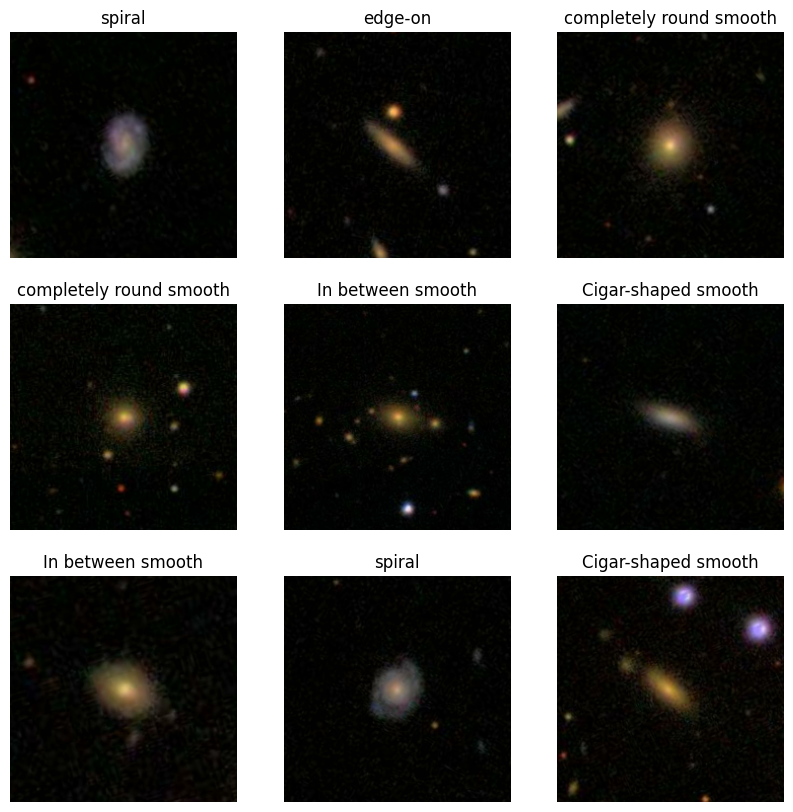

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def collect_data(dataset):
    images_list = []
    labels_list = []

    # Collect all images and labels from the dataset
    for image, label in dataset:
        images_list.append(image.numpy())
        labels_list.append(label.numpy())  # Assuming labels are byte strings

    return images_list, labels_list

def random_sample(images_list, labels_list, num_samples):
    indices = np.random.choice(len(images_list), num_samples, replace=False)
    sampled_images = [images_list[i] for i in indices]
    sampled_labels = [labels_list[i] for i in indices]

    return sampled_images, sampled_labels

def display_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  # Display up to 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i]) # Convert to the index of the max value
        morph_class = [k for k, v in folder_to_class.items() if v == label_idx][0]
        plt.title(morph_class)
        plt.axis('off')
    plt.show()

# Collect all images and labels from the dataset
images_list, labels_list = collect_data(balanced_dataset)

# Randomly sample 9 images and their labels
sampled_images, sampled_labels = random_sample(images_list, labels_list, num_samples=9)

# Display the sampled images and labels
display_images(sampled_images, sampled_labels)

Let's create now the training, the validation and the test set.

In [11]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Define batch size
batch_size = 64

# Function to split the dataset
def split_dataset(dataset, train_ratio, val_ratio):
    dataset_size = len(dataset)
    train_size = int(dataset_size * train_ratio)
    val_size = int(dataset_size * val_ratio)

    # Create train, validation, and test splits
    dataset = dataset.shuffle(buffer_size=min_images * len(folder_to_class))  # Shuffle the dataset before splitting
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

# Split the dataset into training, validation, and test sets
train_ds, val_ds, test_ds = split_dataset(balanced_dataset, train_ratio, val_ratio)

# Apply batching and prefetching to the datasets
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
def count_total_examples(dataset):
    total_count = 0
    for batch in dataset:
        images, _ = batch
        total_count += len(images)
    return total_count

# Verify dataset sizes
train_size = count_total_examples(train_ds)
val_size = count_total_examples(val_ds)
test_size = count_total_examples(test_ds)

print(f"Training dataset size: {train_size} examples")
print(f"Validation dataset size: {val_size} examples")
print(f"Test dataset size: {test_size} examples")

Training dataset size: 2026 examples
Validation dataset size: 434 examples
Test dataset size: 435 examples


In [13]:
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")

Batch of images shape: (64, 224, 224, 3)
Batch of labels shape: (64, 5)


In [14]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

num_classes = len(folder_to_class)

model = Sequential([
    Input((224,224,3)),
    Conv2D(16, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(32, activation = "relu"),
    Dense(num_classes, activation = "softmax")
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       1,384,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,408,229 (5.37 MB)

 Trainable params: 1,408,229 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.2571 - loss: 1.5839 - val_accuracy: 0.4055 - val_loss: 1.4285
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.4904 - loss: 1.3056 - val_accuracy: 0.5092 - val_loss: 1.1299
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.5764 - loss: 1.0393 - val_accuracy: 0.6959 - val_loss: 0.7660
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.6700 - loss: 0.8218 - val_accuracy: 0.7926 - val_loss: 0.6346
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.7351 - loss: 0.6423 - val_accuracy: 0.8111 - val_loss: 0.5415


In [17]:
# We can also use the history (that we saved before) to check the behavior of the training.
# history is a Python dictionary that cointains the values of the behavior of the loss
# during training (one value for each epoch).
def display_history(history):
    mse_training = history.history['loss']
    acc_training = history.history['accuracy']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

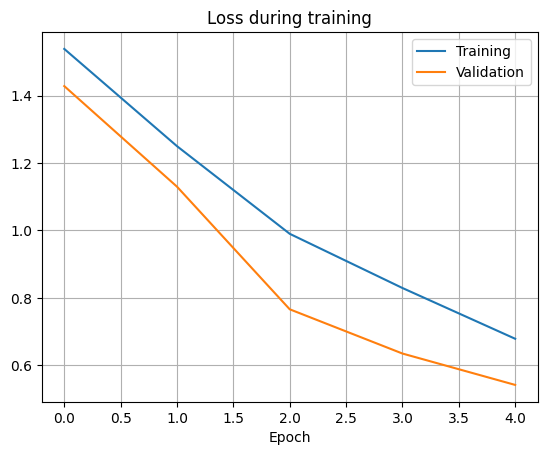

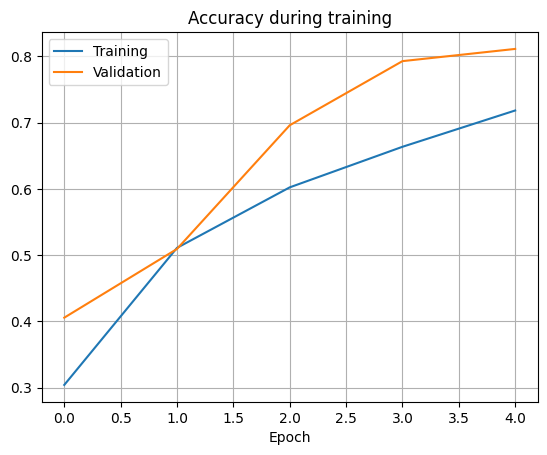

In [18]:
display_history(history)